# Predictive Credit Risk Modeling

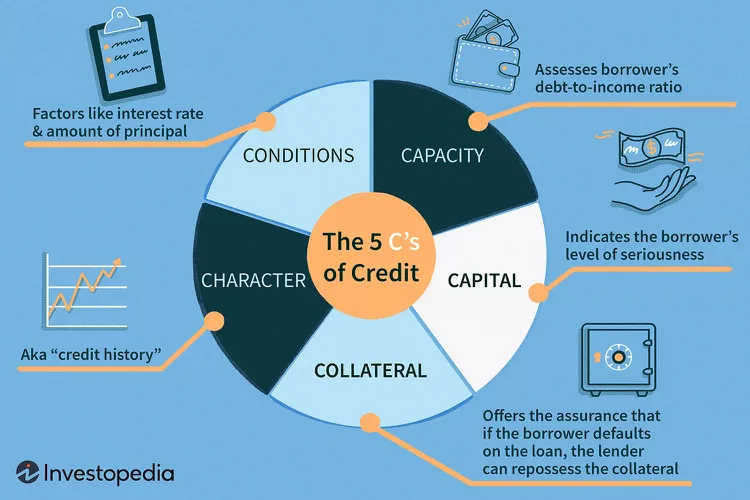

In [337]:
import requests
from PIL import Image
from io import BytesIO
from IPython.display import display

url = "https://www.investopedia.com/thmb/sW2OzUcIrqFeZNVNOPuiJ_PwlBw=/750x0/filters:no_upscale():max_bytes(150000):strip_icc():format(webp)/investopedia5cscredit-5c8ffbb846e0fb00016ee129.jpg"

response = requests.get(url)
img = Image.open(BytesIO(response.content))
display(img)

Predictive credit risk modelling is very important for financial institutions, this is because by using machine learning it can be easier to identify which borrower will not repay their loans and this can also help reduce the Banks Non-Performing Assets (NPA) by identifying hidden traits which are associated with borrowers who may default, which a credit score may not be able to point out, when issuing an unsecured loan it is important for banks to make sure they give credit to a person who is less likely to default.

We are going to use the TransUnion CIBIL dataset, and also Internal Bank dataset from a bank to predict priority levels of the applicant to help banks determine whether to issue a loan or not.

We are also going to delve into resampling of our data to see which method improves our best baseline model.

**Author**: Dakalo Mudimeli  
**Date**: April, 2025 

# Table of Contents

1. [Importing Necessary Packages](#Importing-Necessary-Packages)
2. [Data Loading](#Data-Loading)
3. [Data Cleaning](#Data-Cleaning)
4. [Exploratory Data Analysis](#Exploratory-Data-Analysis)
5. [Feature Selection](#Feature-Selection)
6. [Data Pre processing](#Data-Pre-processing)
7. [Modeling and Evaluation](#Modeling-and-Evaluation)
8. [Handling Data Imbalance](#Handling-Data-Imbalance)
9. [Performance Comparison](#Performance-Comparison)
9. [Conclusion](#Conclusion)

# Importing Necessary Packages

[Return to Contents](#Table-of-Contents) 

In [338]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import chi2_contingency, f_oneway
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score, ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

import shap

import warnings
warnings.filterwarnings("ignore")

# Data Loading

[Return to Contents](#Table-of-Contents) 

In [339]:
# Load data from excel files

CBIL = pd.read_excel('Data/External_Cibil_Dataset.xlsx')
Internal = pd.read_excel('Data/Internal_Bank_Dataset.xlsx')

# Exploratory Data Analysis

[Return to Contents](#Table-of-Contents) 

In [340]:
# Create df1 and df2 for CBIL and Internal Data that we will process, manipulate and clean.
df1 = CBIL.copy()
df2 = Internal.copy()

In [341]:
# Check for Null's and Data Types of all the Features

df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51336 entries, 0 to 51335
Data columns (total 62 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   PROSPECTID                    51336 non-null  int64  
 1   time_since_recent_payment     51336 non-null  int64  
 2   time_since_first_deliquency   51336 non-null  int64  
 3   time_since_recent_deliquency  51336 non-null  int64  
 4   num_times_delinquent          51336 non-null  int64  
 5   max_delinquency_level         51336 non-null  int64  
 6   max_recent_level_of_deliq     51336 non-null  int64  
 7   num_deliq_6mts                51336 non-null  int64  
 8   num_deliq_12mts               51336 non-null  int64  
 9   num_deliq_6_12mts             51336 non-null  int64  
 10  max_deliq_6mts                51336 non-null  int64  
 11  max_deliq_12mts               51336 non-null  int64  
 12  num_times_30p_dpd             51336 non-null  int64  
 13  n

In [342]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51336 entries, 0 to 51335
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   PROSPECTID            51336 non-null  int64  
 1   Total_TL              51336 non-null  int64  
 2   Tot_Closed_TL         51336 non-null  int64  
 3   Tot_Active_TL         51336 non-null  int64  
 4   Total_TL_opened_L6M   51336 non-null  int64  
 5   Tot_TL_closed_L6M     51336 non-null  int64  
 6   pct_tl_open_L6M       51336 non-null  float64
 7   pct_tl_closed_L6M     51336 non-null  float64
 8   pct_active_tl         51336 non-null  float64
 9   pct_closed_tl         51336 non-null  float64
 10  Total_TL_opened_L12M  51336 non-null  int64  
 11  Tot_TL_closed_L12M    51336 non-null  int64  
 12  pct_tl_open_L12M      51336 non-null  float64
 13  pct_tl_closed_L12M    51336 non-null  float64
 14  Tot_Missed_Pmnt       51336 non-null  int64  
 15  Auto_TL            

In [343]:
# Let's look at the summary statistics of numeric features and check for values which are not normal

numeric_features = []

for column in df1.columns:
    if df1[column].dtype != 'object':
        numeric_features.append(column)

df1[numeric_features].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
PROSPECTID,51336.0,25668.500000,14819.571046,1.0,12834.750,25668.500,38502.25000,51336.000
time_since_recent_payment,51336.0,-8129.961314,27749.328514,-99999.0,46.000,70.000,161.00000,6065.000
time_since_first_deliquency,51336.0,-70020.091320,45823.312757,-99999.0,-99999.000,-99999.000,8.00000,35.000
time_since_recent_deliquency,51336.0,-70022.375838,45819.820741,-99999.0,-99999.000,-99999.000,3.00000,35.000
num_times_delinquent,51336.0,1.573749,4.165012,0.0,0.000,0.000,1.00000,74.000
max_delinquency_level,51336.0,-70003.987085,45847.976100,-99999.0,-99999.000,-99999.000,15.00000,900.000
max_recent_level_of_deliq,51336.0,13.521953,53.336976,0.0,0.000,0.000,10.00000,900.000
num_deliq_6mts,51336.0,0.184977,0.710240,0.0,0.000,0.000,0.00000,12.000
num_deliq_12mts,51336.0,0.480053,1.522210,0.0,0.000,0.000,0.00000,28.000
num_deliq_6_12mts,51336.0,0.295076,1.027471,0.0,0.000,0.000,0.00000,20.000


In [344]:
numeric_features2 = []

for column in df2.columns:
    if df2[column].dtype != 'object':
        numeric_features2.append(column)

df2[numeric_features2].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
PROSPECTID,51336.0,25668.500000,14819.571046,1.0,12834.75,25668.500,38502.250,51336.0
Total_TL,51336.0,4.858598,7.177116,1.0,1.00,2.000,5.000,235.0
Tot_Closed_TL,51336.0,2.770415,5.941680,0.0,0.00,1.000,3.000,216.0
Tot_Active_TL,51336.0,2.088184,2.290774,0.0,1.00,1.000,3.000,47.0
Total_TL_opened_L6M,51336.0,0.736754,1.296717,0.0,0.00,0.000,1.000,27.0
Tot_TL_closed_L6M,51336.0,0.428919,0.989972,0.0,0.00,0.000,1.000,19.0
pct_tl_open_L6M,51336.0,0.184574,0.297414,0.0,0.00,0.000,0.308,1.0
pct_tl_closed_L6M,51336.0,0.089095,0.205635,0.0,0.00,0.000,0.053,1.0
pct_active_tl,51336.0,0.577542,0.379867,0.0,0.25,0.556,1.000,1.0
pct_closed_tl,51336.0,0.422458,0.379867,0.0,0.00,0.444,0.750,1.0


For most of the values on df1 and df2 we have -99999, which we know is supposed to be a positive value and could mean they are null values, so we are going to count how many of the null values are there in each dataframe and column, then decide what to do with them.

In [345]:
# check the number of -99999 values for each column and also the percentage of the total data

summary_df1 = pd.DataFrame({'Column': df1.columns, 'Count': (df1 == -99999).sum().values, 'Percentage': ((df1 == -99999).sum()/df1.shape[0]).values*100})
pd.set_option('display.max_rows', None)
summary_df2 = pd.DataFrame({'Column': df2.columns, 'Count': (df2 == -99999).sum().values, 'Percentage': ((df2 == -99999).sum()/df2.shape[0]).values*100})
pd.set_option('display.max_rows', None)

In [346]:
print(summary_df1)

                          Column  Count  Percentage
0                     PROSPECTID      0    0.000000
1      time_since_recent_payment   4291    8.358657
2    time_since_first_deliquency  35949   70.026882
3   time_since_recent_deliquency  35949   70.026882
4           num_times_delinquent      0    0.000000
5          max_delinquency_level  35949   70.026882
6      max_recent_level_of_deliq      0    0.000000
7                 num_deliq_6mts      0    0.000000
8                num_deliq_12mts      0    0.000000
9              num_deliq_6_12mts      0    0.000000
10                max_deliq_6mts  12890   25.109085
11               max_deliq_12mts  10832   21.100203
12             num_times_30p_dpd      0    0.000000
13             num_times_60p_dpd      0    0.000000
14                       num_std      0    0.000000
15                  num_std_6mts      0    0.000000
16                 num_std_12mts      0    0.000000
17                       num_sub      0    0.000000
18          

In [347]:
print(summary_df2)

                  Column  Count  Percentage
0             PROSPECTID      0    0.000000
1               Total_TL      0    0.000000
2          Tot_Closed_TL      0    0.000000
3          Tot_Active_TL      0    0.000000
4    Total_TL_opened_L6M      0    0.000000
5      Tot_TL_closed_L6M      0    0.000000
6        pct_tl_open_L6M      0    0.000000
7      pct_tl_closed_L6M      0    0.000000
8          pct_active_tl      0    0.000000
9          pct_closed_tl      0    0.000000
10  Total_TL_opened_L12M      0    0.000000
11    Tot_TL_closed_L12M      0    0.000000
12      pct_tl_open_L12M      0    0.000000
13    pct_tl_closed_L12M      0    0.000000
14       Tot_Missed_Pmnt      0    0.000000
15               Auto_TL      0    0.000000
16                 CC_TL      0    0.000000
17           Consumer_TL      0    0.000000
18               Gold_TL      0    0.000000
19               Home_TL      0    0.000000
20                 PL_TL      0    0.000000
21            Secured_TL      0 

In [348]:
# We will retain columns where the percentage of Nulls is less than 20%
nulls = []
for column in numeric_features:
    percent = df1.loc[df1[column] == -99999].shape[0]/df1[column].shape[0]
    if percent > 0.2:
        nulls.append(column)
        print('Dropped ', column)
df1.drop(nulls, axis = 1, inplace = True)

Dropped  time_since_first_deliquency
Dropped  time_since_recent_deliquency
Dropped  max_delinquency_level
Dropped  max_deliq_6mts
Dropped  max_deliq_12mts
Dropped  CC_utilization
Dropped  PL_utilization
Dropped  max_unsec_exposure_inPct


In [349]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51336 entries, 0 to 51335
Data columns (total 54 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   PROSPECTID                  51336 non-null  int64  
 1   time_since_recent_payment   51336 non-null  int64  
 2   num_times_delinquent        51336 non-null  int64  
 3   max_recent_level_of_deliq   51336 non-null  int64  
 4   num_deliq_6mts              51336 non-null  int64  
 5   num_deliq_12mts             51336 non-null  int64  
 6   num_deliq_6_12mts           51336 non-null  int64  
 7   num_times_30p_dpd           51336 non-null  int64  
 8   num_times_60p_dpd           51336 non-null  int64  
 9   num_std                     51336 non-null  int64  
 10  num_std_6mts                51336 non-null  int64  
 11  num_std_12mts               51336 non-null  int64  
 12  num_sub                     51336 non-null  int64  
 13  num_sub_6mts                513

Now let us have a look at Categorical Features

In [350]:
# Let's look at the categorical features

categorical_features = []

for column in df1.columns:
    if df1[column].dtype == 'object':
        categorical_features.append(column)

df1[categorical_features].describe().transpose()

,count,unique,top,freq
MARITALSTATUS,51336,2,Married,37752
EDUCATION,51336,7,GRADUATE,16673
GENDER,51336,2,M,45245
last_prod_enq2,51336,6,others,20831
first_prod_enq2,51336,6,others,28120
Approved_Flag,51336,4,P2,32199


In [351]:
# Unique values for MARITALSTATUS

df1['MARITALSTATUS'].unique()

array(['Married', 'Single'], dtype=object)

In [352]:
# Count the number of entries for each category in MARITALSTATUS

for category in df1['MARITALSTATUS'].unique():
    count = df1.loc[df1['MARITALSTATUS'] == category].shape[0]
    print(category, count)

Married 37752
Single 13584


<Axes: xlabel='count', ylabel='MARITALSTATUS'>

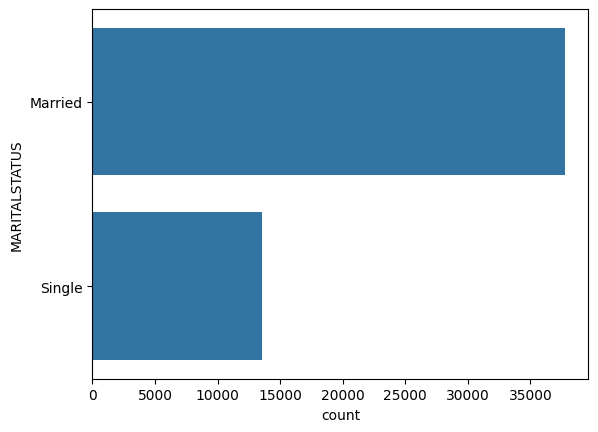

In [353]:
sns.countplot(df1['MARITALSTATUS'])

In [354]:
# Unique values for EDUCATION

df1['EDUCATION'].unique()

array(['12TH', 'GRADUATE', 'SSC', 'POST-GRADUATE', 'UNDER GRADUATE',
       'OTHERS', 'PROFESSIONAL'], dtype=object)

In [355]:
# Count the number of entries for each category in EDUCATION

for category in df1['EDUCATION'].unique():
    count = df1.loc[df1['EDUCATION'] == category].shape[0]
    print(category, count)

12TH 14467
GRADUATE 16673
SSC 9276
POST-GRADUATE 2242
UNDER GRADUATE 5492
OTHERS 2917
PROFESSIONAL 269


<Axes: xlabel='count', ylabel='EDUCATION'>

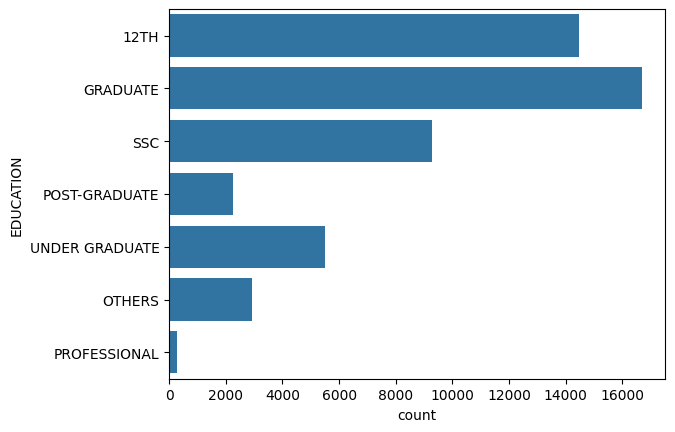

In [356]:
sns.countplot(df1['EDUCATION'])

In [357]:
# Unique values for GENDER

df1['GENDER'].unique()

array(['M', 'F'], dtype=object)

In [358]:
# Count the number of entries for each category in GENDER

for category in df1['GENDER'].unique():
    count = df1.loc[df1['GENDER'] == category].shape[0]
    print(category, count)

M 45245
F 6091


<Axes: xlabel='count', ylabel='GENDER'>

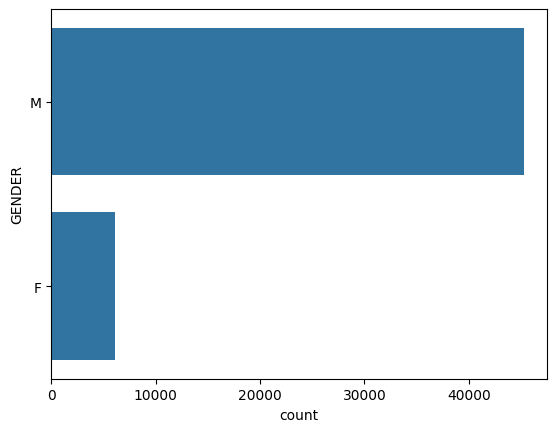

In [359]:
sns.countplot(df1['GENDER'])

In [360]:
# Unique values for last_prod_en2

df1['last_prod_enq2'].unique()

array(['PL', 'ConsumerLoan', 'others', 'AL', 'CC', 'HL'], dtype=object)

In [361]:
# Count the number of entries for each category in 'last_prod_enq2'

for category in df1['last_prod_enq2'].unique():
    count = df1.loc[df1['last_prod_enq2'] == category].shape[0]
    print(category, count)

PL 7959
ConsumerLoan 17793
others 20831
AL 1511
CC 2339
HL 903


<Axes: xlabel='count', ylabel='last_prod_enq2'>

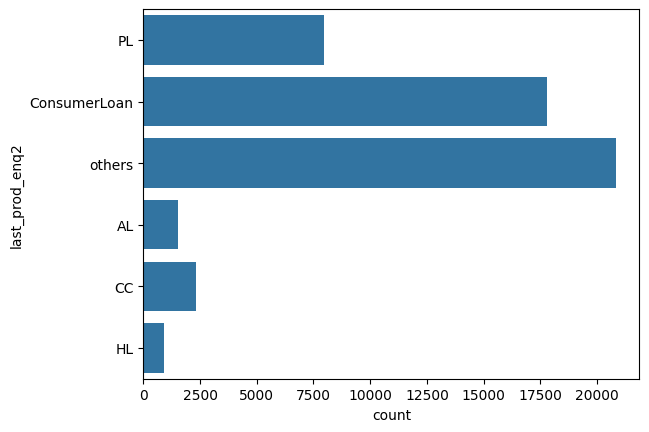

In [362]:
sns.countplot(df1['last_prod_enq2'])

In [363]:
# Unique values for first_prod_enq2

df1['first_prod_enq2'].unique()

array(['PL', 'ConsumerLoan', 'others', 'AL', 'HL', 'CC'], dtype=object)

In [364]:
# Count the number of entries for each category in 'first_prod_enq2'

for category in df1['first_prod_enq2'].unique():
    count = df1.loc[df1['first_prod_enq2'] == category].shape[0]
    print(category, count)

PL 4889
ConsumerLoan 11860
others 28120
AL 2870
HL 1409
CC 2188


<Axes: xlabel='count', ylabel='first_prod_enq2'>

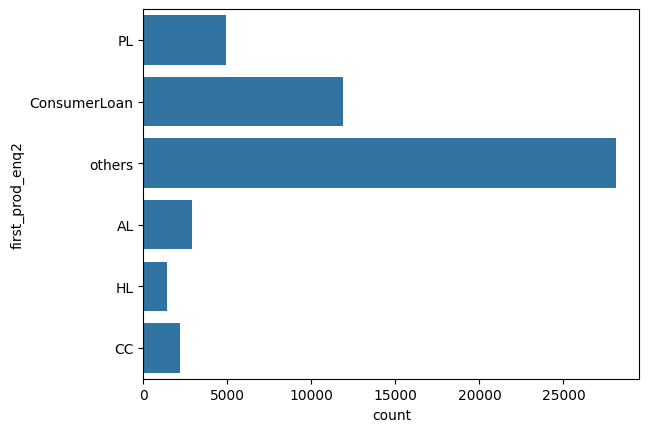

In [365]:
sns.countplot(df1['first_prod_enq2'], )

In [366]:
# Unique values for Approved_Flag

df1['Approved_Flag'].unique()

array(['P2', 'P1', 'P3', 'P4'], dtype=object)

In [367]:
# Count the number of entries for each category in 'first_prod_enq2'

for category in df1['Approved_Flag'].unique():
    count = df1.loc[df1['Approved_Flag'] == category].shape[0]
    print(category, count)

P2 32199
P1 5803
P3 7452
P4 5882


<Axes: xlabel='count', ylabel='Approved_Flag'>

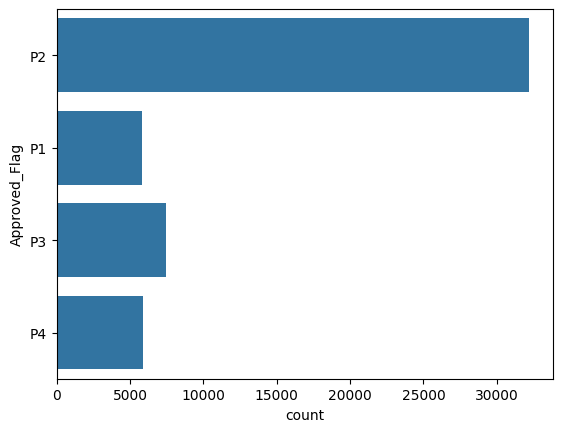

In [368]:
sns.countplot(df1['Approved_Flag'])

In [369]:
# Proportion of target variable

total = df1['Approved_Flag'].shape[0]
for cat_class in df1['Approved_Flag'].unique():
    cat_total = (df1.loc[df1['Approved_Flag'] == cat_class]).shape[0]
    print(cat_class, cat_total/total*100,'%')

P2 62.72206638616176 %
P1 11.303958235935795 %
P3 14.516129032258066 %
P4 11.457846345644382 %


We can see in the data we have that we do have dominant classes and non dominant classes, when it comes to classification this is may not be good, because our model may be very good at predicting P2 than other Priority Levels, we may need to deal with this data imbalance, but we will look into it later on if it is neccessary.

In [370]:
# Merge the two datasets and make PROSPECTID'

df = pd.merge(df2, df1, how='inner', on = 'PROSPECTID')
df = df.set_index('PROSPECTID')

# Feature Selection

[Return to Contents](#Table-of-Contents) 

We need to check if any of our Features are associated with our Target variable 'Approved_Flag',

There are ways we can do this by using statistical tests:
- Chi-Square test: This is used for checking categorical variables against categorical variables
- T-test: This is used on categorical variables against numerical variables,  maximum number of categories is 2
- Anova: This is used on Categorical variables against numerical variables for categories greater than or equals to 3

In [371]:
# Chi-square test on categorical variables using alpha of 5%(0.05)

dropped_column = []

for column in df.columns:
    if df[column].dtype == 'object' and column != 'Approved_Flag':
        freq_table = pd.crosstab(df[column], df['Approved_Flag'])
        chi = chi2_contingency(freq_table)
        if chi.pvalue >= 0.05:
            dropped_column.append(column)
            print(column, chi.pvalue)

In [372]:
# Anova test on numerical and categorical target variable using alpha of 5%

dropped_column = []
for column in df.columns:
    if df[column].dtype != 'object' and column not in 'Approved_Flag':
        features = list(df[column])
        target = list(df['Approved_Flag'])

        P1 = [value for value, category in zip(features, target) if category == 'P1']
        P2 = [value for value, category in zip(features, target) if category == 'P2']
        P3 = [value for value, category in zip(features, target) if category == 'P3']
        P4 = [value for value, category in zip(features, target) if category == 'P4']

        stat = f_oneway(P1, P2, P3, P4)
        if stat.pvalue >= 0.05:
            dropped_column.append(column)
            print('dropped', column)
df.drop(dropped_column, axis=1, inplace = True)

dropped num_sub_6mts
dropped num_dbt_6mts
dropped num_lss_6mts
dropped num_lss_12mts
dropped pct_currentBal_all_TL


#### Multicollinearity

<Axes: >

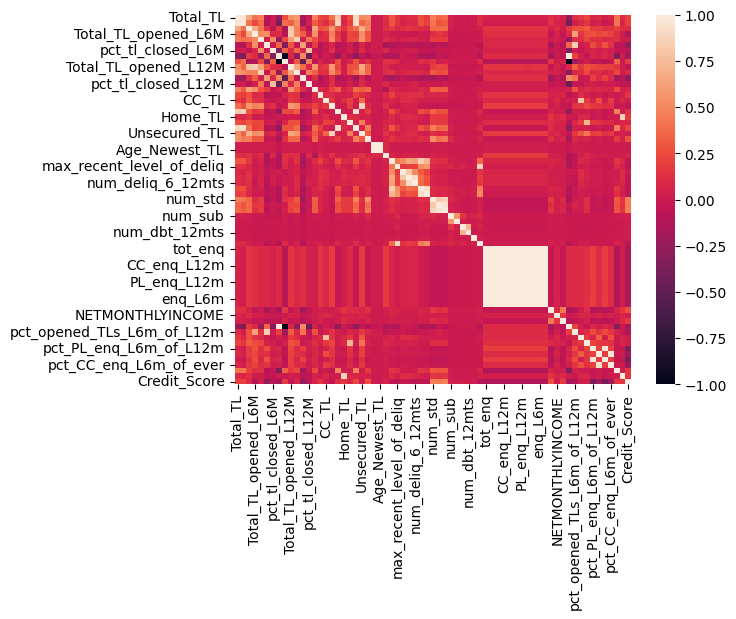

In [373]:
# Correlation matrix of numerical variables

numeric_columns = [column for column in df.columns if df[column].dtype != 'object']

sns.heatmap(df[numeric_columns].corr())

In [374]:
# Let us check the predictability of each of our features by other features then sequentially drop the features with high Multicollinearity.

indx = 0
numeric_columns = [column for column in df.columns if df[column].dtype != 'object']
df3 = df[numeric_columns]
dropped_column = []
columns = df3.columns
for column in columns:
    vif = variance_inflation_factor(df3, indx)
    if vif > 5:
        df3.drop(column, axis = 1, inplace= True)
        print('dropped', column, vif)
        dropped_column.append(column)
    else:
        indx +=1

df.drop(dropped_column, axis = 1, inplace = True)
print(len(dropped_column), 'columns dropped')

dropped Total_TL inf
dropped Tot_Closed_TL inf
dropped Tot_Active_TL 10.958454980997187
dropped Total_TL_opened_L6M 8.244415258974355
dropped Tot_TL_closed_L6M 6.4284192887853475
dropped pct_tl_open_L6M 5.449852929688894
dropped pct_active_tl inf
dropped pct_closed_tl 1776.8723571965445
dropped Total_TL_opened_L12M 8.220961534778702
dropped Auto_TL inf
dropped Consumer_TL 21.051292296483048
dropped Gold_TL 31.962131682431227
dropped Age_Oldest_TL 9407.501894047877
dropped num_times_delinquent 8.00256974971181
dropped max_recent_level_of_deliq 5.3845868423595835
dropped num_deliq_6mts inf
dropped num_deliq_12mts 7.266905126451073
dropped num_times_30p_dpd 8.497774267254352
dropped num_std 7.051442187239146
dropped num_std_6mts 15.386532399875732
dropped tot_enq 342247358.9549353
dropped CC_enq 2981559643.5253034
dropped CC_enq_L6m 11936926994.777119
dropped CC_enq_L12m 1411308243.7319436
dropped PL_enq 1785330457.1670883
dropped PL_enq_L6m 5319228911.788497
dropped PL_enq_L12m 491289968

In [375]:
df.head()

,pct_tl_closed_L6M,Tot_TL_closed_L12M,pct_tl_open_L12M,pct_tl_closed_L12M,Tot_Missed_Pmnt,CC_TL,Home_TL,PL_TL,Secured_TL,Unsecured_TL,...,pct_opened_TLs_L6m_of_L12m,CC_Flag,PL_Flag,pct_PL_enq_L6m_of_ever,pct_CC_enq_L6m_of_ever,HL_Flag,GL_Flag,last_prod_enq2,first_prod_enq2,Approved_Flag
PROSPECTID,,,,,,,,,,,,,,,,,,,,,
1,0.0,0,0.00,0.0,0,0,0,4,1,4,...,0.0,0,1,0.0,0.0,1,0,PL,PL,P2
2,0.0,0,1.00,0.0,0,0,0,0,0,1,...,0.0,0,0,0.0,0.0,0,0,ConsumerLoan,ConsumerLoan,P2
3,0.0,0,0.25,0.0,1,0,0,0,2,6,...,0.5,0,0,0.0,0.0,1,0,ConsumerLoan,others,P2
4,0.0,0,1.00,0.0,1,0,0,0,0,1,...,1.0,0,0,0.0,0.0,0,0,others,others,P2
5,0.0,0,0.00,0.0,0,0,0,0,3,0,...,0.0,0,0,0.0,0.0,0,0,AL,AL,P1


<Axes: >

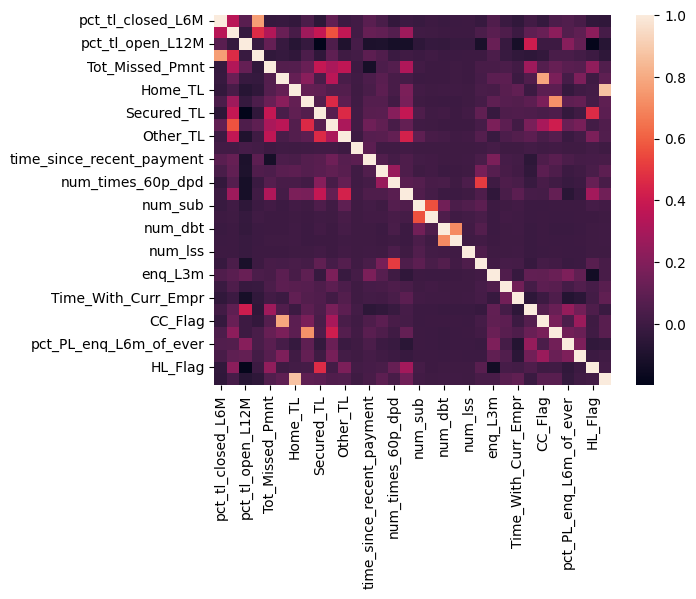

In [376]:
# Let us have a look at the correlation matrix

numeric_columns = [column for column in df.columns if df[column].dtype != 'object']

sns.heatmap(df[numeric_columns].corr())

We can see that multicolinearity is greatly reduced

# Data Pre processing

[Return to Contents](#Table-of-Contents) 

We are going to convert our categorical features using label encoding and one hot encoding based on which method is suitable for each feature.

In [377]:
# From our EDA section we only have one column 'EDUCATION' where we need to apply label encoding

df['EDUCATION'].unique()

array(['12TH', 'GRADUATE', 'SSC', 'POST-GRADUATE', 'UNDER GRADUATE',
       'OTHERS', 'PROFESSIONAL'], dtype=object)

In [378]:
# Manually apply label encoding based on the level of Education

# Secondary = 1
# 12th = 2
# Under Graduate = 3
# Graduate = 4
# Post-Graduate = 5
# Professional = 6
# Others = 1

education_level = {
    'SSC': 1,
    '12TH': 2,
    'UNDER GRADUATE': 3,
    'GRADUATE': 4,
    'POST-GRADUATE': 5,
    'PROFESSIONAL': 6,
    'OTHERS': 1
}

df['EDUCATION'] = df['EDUCATION'].replace(education_level)

df['EDUCATION'].head()

PROSPECTID
1    2
2    4
3    1
4    1
5    5
Name: EDUCATION, dtype: int64

In [379]:
# One Hot Encoder

encoder = OneHotEncoder(sparse_output= False, drop = None)
encoder = ColumnTransformer([('onehot', encoder,['MARITALSTATUS', 'GENDER', 'last_prod_enq2', 'first_prod_enq2'])], remainder = 'passthrough')
df_encoded_array = encoder.fit_transform(df)
encoded_columns = encoder.get_feature_names_out()
encoded_columns = [column.replace('onehot__','') for column in encoded_columns]
encoded_columns = [column.replace('remainder__','') for column in encoded_columns]
df_encoded = pd.DataFrame(df_encoded_array, columns = encoded_columns)

df_encoded.head()


,MARITALSTATUS_Married,MARITALSTATUS_Single,GENDER_F,GENDER_M,last_prod_enq2_AL,last_prod_enq2_CC,last_prod_enq2_ConsumerLoan,last_prod_enq2_HL,last_prod_enq2_PL,last_prod_enq2_others,...,NETMONTHLYINCOME,Time_With_Curr_Empr,pct_opened_TLs_L6m_of_L12m,CC_Flag,PL_Flag,pct_PL_enq_L6m_of_ever,pct_CC_enq_L6m_of_ever,HL_Flag,GL_Flag,Approved_Flag
0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,51000,114,0.0,0,1,0.0,0.0,1,0,P2
1,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,19000,50,0.0,0,0,0.0,0.0,0,0,P2
2,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,18,191,0.5,0,0,0.0,0.0,1,0,P2
3,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,10000,246,1.0,0,0,0.0,0.0,0,0,P2
4,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,15000,75,0.0,0,0,0.0,0.0,0,0,P1


In [380]:
# Separate the predictors and the target into X and y

X = df_encoded.drop('Approved_Flag', axis = 1).astype(float)
y = df_encoded['Approved_Flag']

In [381]:
# split the data into train and test data

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

<Axes: xlabel='count', ylabel='Approved_Flag'>

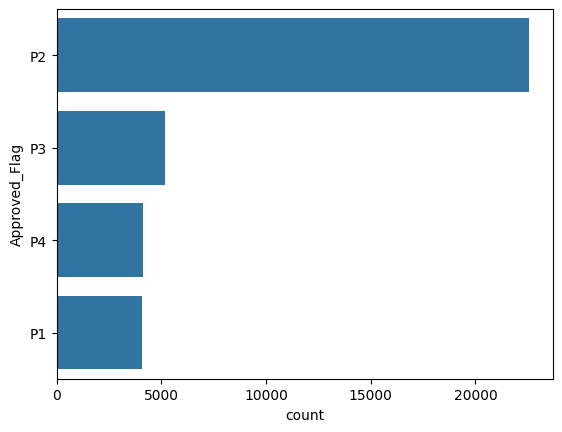

In [382]:
sns.countplot(y_train)

<Axes: xlabel='count', ylabel='Approved_Flag'>

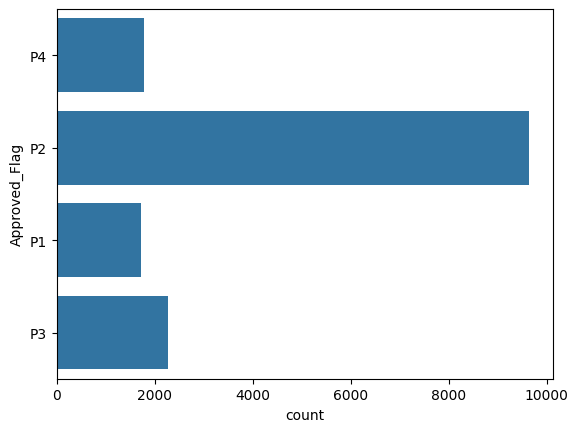

In [383]:
sns.countplot(y_test)

# Modeling and Evaluation

[Return to Contents](#Table-of-Contents) 

We are going to train machine learning models and predict the Approved Flag and we we will see which model performs the best, the method we are going to use to check our models is F1 Score

### Random Forest

In [384]:
# Random forest classifier

rf_clf = RandomForestClassifier(random_state = 42)

In [385]:
# Fit the random forest classifier

rf_clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [386]:
# Make predictions on test data

y_pred = rf_clf.predict(X_test)

In [387]:
# Check the accuracy of the Random Forest Classifier

accuracy = accuracy_score(y_test, y_pred)
print('accuracy:', accuracy)

accuracy: 0.736965132134277


In [388]:
# Calculate precision, recall and f1 score

precision = precision_score(y_test, y_pred, average= None)
recall = recall_score(y_test, y_pred, average= None)
f1 = f1_score(y_true = y_test, y_pred = y_pred, average = None)
# display precision, recall and f1 score by class

category = ['P1', 'P2', 'P3', 'P4']
for i in range(4):
    print(category[i], 'Precision:','%.2f' %precision[i], 'Recall:', '%.2f' %recall[i], 'F1 Score:', '%.2f' %f1[i])


P1 Precision: 0.76 Recall: 0.43 F1 Score: 0.55
P2 Precision: 0.76 Recall: 0.94 F1 Score: 0.84
P3 Precision: 0.44 Recall: 0.17 F1 Score: 0.24
P4 Precision: 0.71 Recall: 0.67 F1 Score: 0.69


In [389]:
# Precision, Recall and F1 Score of the model

precision = precision_score(y_test, y_pred, average= 'weighted')
recall = recall_score(y_test, y_pred, average= 'weighted')
f1 = f1_score(y_test, y_pred, average= 'weighted')

print('Precision:','%.2f' %precision, 'Recall:', '%.2f' %recall, 'F1 Score:', '%.2f' %f1)

Precision: 0.71 Recall: 0.74 F1 Score: 0.70


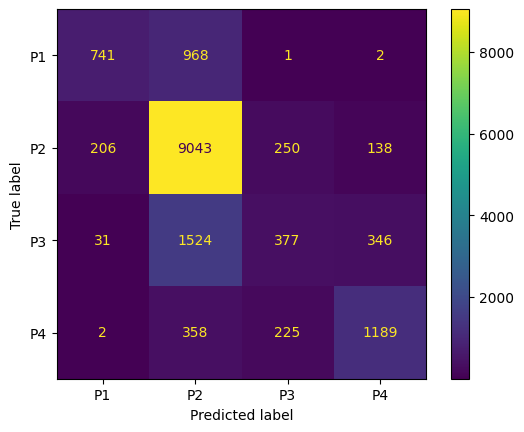

In [390]:
# Create a confusion matrix to see how the model was able to predict each class

y_true = np.array(y_test)
y_pred = np.array(y_pred)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.show()

The Random Forest Classifier performs very well on predicting priority level 2 and not very well on Priority level 3.

Let us try Decision Tree


### Decision Tree

In [391]:
# Decision Tree classifier

dt_clf = DecisionTreeClassifier(random_state= 42)

In [392]:
# Train the model using train dataset

dt_clf.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [393]:
# Make predictions on test dataset

y_pred = dt_clf.predict(X_test)

In [394]:
# Accuracy

accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)

Accuracy: 0.6472956301538861


In [395]:
# Evaluation metrics

precision = precision_score(y_test, y_pred, average=None)
recall = recall_score(y_test, y_pred, average=None)
f1 = f1_score(y_test, y_pred, average=None)
# display precision, recall and f1 score by class

category = ['P1', 'P2', 'P3', 'P4']
for i in range(4):
    print(category[i], 'Precision:','%.2f' %precision[i], 'Recall:', '%.2f' %recall[i], 'F1 Score:', '%.2f' %f1[i])

P1 Precision: 0.48 Recall: 0.47 F1 Score: 0.48
P2 Precision: 0.78 Recall: 0.77 F1 Score: 0.77
P3 Precision: 0.30 Recall: 0.32 F1 Score: 0.31
P4 Precision: 0.59 Recall: 0.59 F1 Score: 0.59


In [396]:
# Model evaluation metrics

precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
print('Precision:','%.2f' %precision, 'Recall:', '%.2f' %recall, 'F1 Score:', '%.2f' %f1)

Precision: 0.65 Recall: 0.65 F1 Score: 0.65


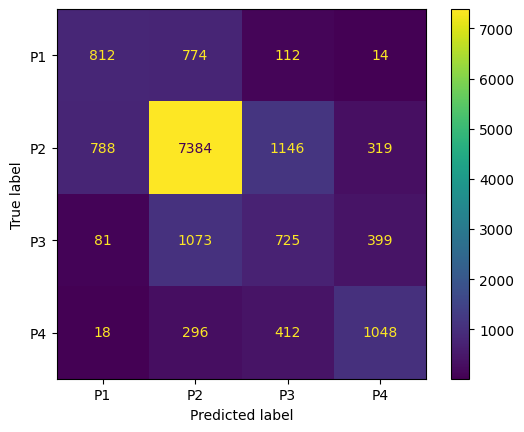

In [397]:
# Create a confusion matrix to see how the model was able to predict each class

y_true = np.array(y_test)
y_pred = np.array(y_pred)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.show()

### XGBoost

In [398]:
# XGBoost Classifier

xgb_clf = XGBClassifier(objective ='multi:softmax', num_class = 4, random_state = 42)

In [399]:
# Apply Label Encoding on Approved_Flag

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)

In [400]:
# Fit model

xgb_clf.fit(X_train, y_train_encoded)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_class=4, ...)

In [401]:
# Predict using test data

y_pred = xgb_clf.predict(X_test)
y_pred = label_encoder.inverse_transform(y_pred)

In [402]:
# Accuracy

accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)

Accuracy: 0.7462502434906825


In [403]:
# Evaluation metrics

precision = precision_score(y_test, y_pred, average=None)
recall = recall_score(y_test, y_pred, average=None)
f1 = f1_score(y_test, y_pred, average=None)
# display precision, recall and f1 score by class

category = ['P1', 'P2', 'P3', 'P4']
for i in range(4):
    print(category[i], 'Precision:','%.2f' %precision[i], 'Recall:', '%.2f' %recall[i], 'F1 Score:', '%.2f' %f1[i])

P1 Precision: 0.73 Recall: 0.52 F1 Score: 0.61
P2 Precision: 0.79 Recall: 0.92 F1 Score: 0.85
P3 Precision: 0.44 Recall: 0.24 F1 Score: 0.31
P4 Precision: 0.71 Recall: 0.68 F1 Score: 0.70


In [404]:
# Model evaluation metrics

precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
print('Precision:','%.2f' %precision, 'Recall:', '%.2f' %recall, 'F1 Score:', '%.2f' %f1)

Precision: 0.72 Recall: 0.75 F1 Score: 0.72


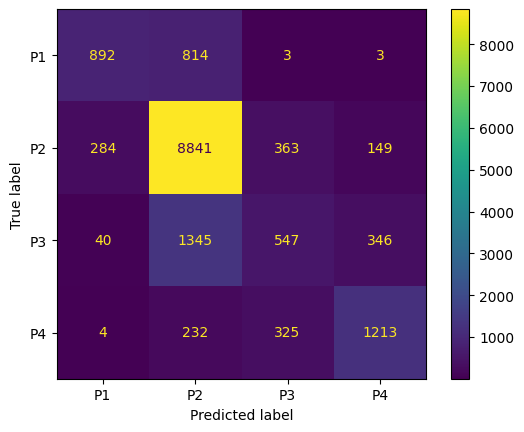

In [405]:
# Create a confusion matrix to see how the model was able to predict each class

y_true = np.array(y_test)
y_pred = np.array(y_pred)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.show()

# Handling Data Imbalance

[Return to Contents](#Table-of-Contents) 

Our model performance is okay, but it can be improved by addressing the imbalance in our data, there are two methods of dealing with the imbalance in data which are Upsampling and Downsampling, we are going to look at each one and evaluate how each influence our baseline models

## Downsampling

In [406]:
from sklearn.utils import resample

In [407]:
class_counts = y_train.value_counts()
class_counts

Approved_Flag
P2    22562
P3     5174
P4     4108
P1     4091
Name: count, dtype: int64

In [408]:
X_resampled, y_resampled = resample(X_train[y_train == 'P2'],
                                         y_train[y_train == 'P2'],
                                         replace = False,
                                         n_samples = np.sum(y_train == 'P1'),
                                         random_state = 42)

In [409]:
X_resampled.shape[0]

4091

In [410]:
X_downsampled = pd.concat([X_train[y_train != 'P2'], X_resampled], ignore_index=True)
y_downsampled = pd.concat([y_train[y_train != 'P2'], y_resampled], ignore_index=True)


In [411]:
# split the data into train and test data

# X_train_ds, X_test_ds, y_train_ds, y_test_ds = train_test_split(X_downsampled, y_downsampled, test_size = 0.2, random_state = 42)

## Upsampling

Now we are going to use Synthetic Minority Over-sampling Technique

In [412]:
from imblearn.over_sampling import SMOTE

In [413]:
# Upsampling using SMOTE

smote = SMOTE(random_state=42)
X_upsampled, y_upsampled = smote.fit_resample(X_train, y_train)

In [414]:
y_upsampled.value_counts()

Approved_Flag
P2    22562
P3    22562
P4    22562
P1    22562
Name: count, dtype: int64

# Performance Comparison

[Return to Contents](#Table-of-Contents) 

In [415]:
# Create a dataframe where we will store our evaluation metrics to compare later

results_df = pd.DataFrame(columns=['Model','Test Accuracy','Test Precision (weighted)', 'Test Recall (weighted)', 'Train F1 Score (weighted)', 'Test F1 Score (weighted)', 'Train Data', 'CV F1 Mean', 'CV F1 Std'])

In [416]:
# Model evaluation function

def evaluation(df, X_train, y_train, X_test, y_test,  trainDatatype, encoder, model1, model2, model3):

    models = [model1, model2, model3]


    model1.fit(X_train, y_train)
    
    model2.fit(X_train, y_train)
    
    y_train_encoded = encoder.transform(y_train)
    model3.fit(X_train, y_train_encoded)
    
    models = [model1, model2, model3]

    for model in models:
        
        print('Training ', type(model).__name__)

        if type(model).__name__ == 'XGBClassifier':

            y_train_encoded = encoder.transform(y_train)
            model.fit(X_train, y_train_encoded)
            y_pred = encoder.inverse_transform(model.predict(X_test))
            y_pred_train = encoder.inverse_transform(model.predict(X_train))

            cv_scores = cross_val_score(model, X_train, y_train_encoded, cv = 5, scoring = 'f1_weighted')

        else:
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            y_pred_train = model.predict(X_train)

            cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='f1_weighted')
        
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='weighted')
        recall = recall_score(y_test, y_pred, average='weighted')
        f1 = f1_score(y_test, y_pred, average='weighted')
        f1_train = f1_score(y_train, y_pred_train, average='weighted')

        new_data = {
            'Model': type(model).__name__,
            'Test Accuracy': accuracy,
            'Test Precision (weighted)': precision,
            'Test Recall (weighted)': recall,
            'Train F1 Score (weighted)': f1_train,
            'Test F1 Score (weighted)': f1,
            'Train Data': trainDatatype,
            'CV F1 Mean': np.mean(cv_scores),
            'CV F1 Std': np.std(cv_scores)
            }
        df = pd.concat([df, pd.DataFrame([new_data])], ignore_index = True)
        print(type(model).__name__, 'Confusion Matrix')
        y_test = np.array(y_test)
        y_pred = np.array(y_pred)
        ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
        plt.show()
        
    return df

Training  RandomForestClassifier
RandomForestClassifier Confusion Matrix


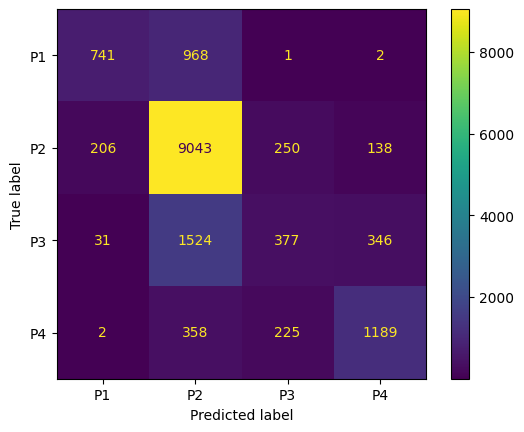

Training  DecisionTreeClassifier
DecisionTreeClassifier Confusion Matrix


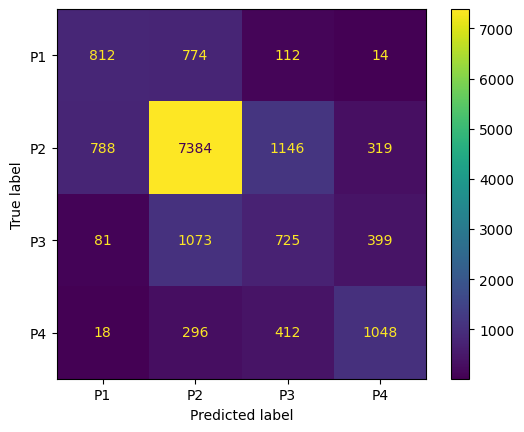

Training  XGBClassifier
XGBClassifier Confusion Matrix


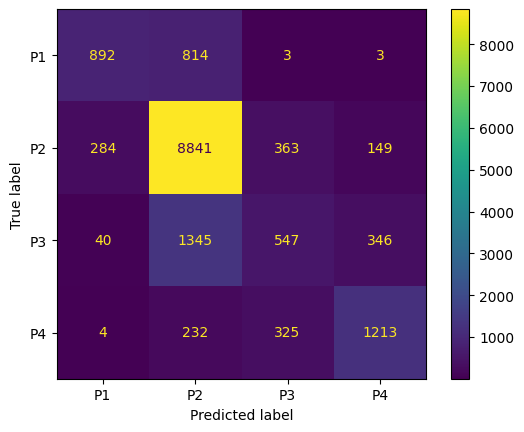

In [417]:
df1 = evaluation(results_df, X_train, y_train, X_test, y_test, 'Original', label_encoder, rf_clf, dt_clf, xgb_clf)

Training  RandomForestClassifier
RandomForestClassifier Confusion Matrix


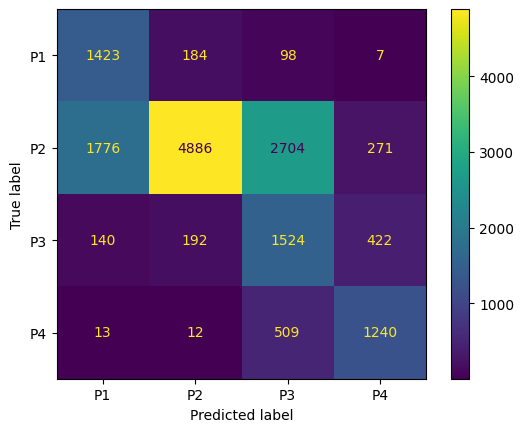

Training  DecisionTreeClassifier
DecisionTreeClassifier Confusion Matrix


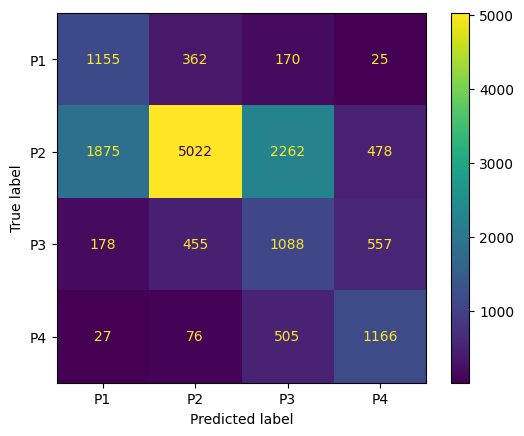

Training  XGBClassifier
XGBClassifier Confusion Matrix


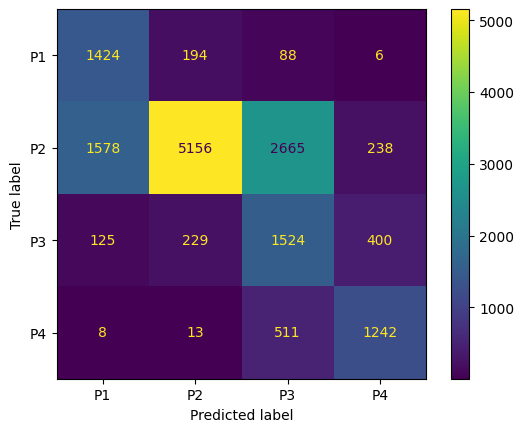

In [418]:
df2 = evaluation(results_df, X_downsampled, y_downsampled, X_test, y_test, 'Downsampled', label_encoder, rf_clf, dt_clf, xgb_clf)

Training  RandomForestClassifier
RandomForestClassifier Confusion Matrix


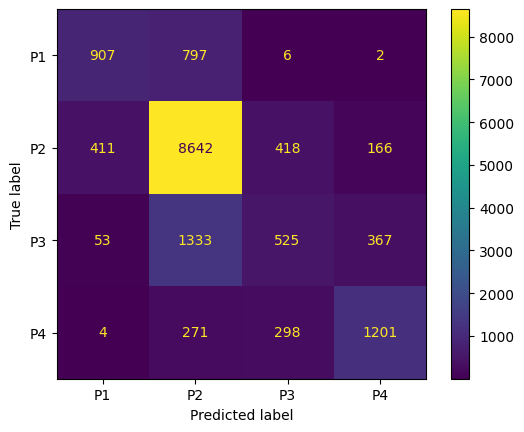

Training  DecisionTreeClassifier
DecisionTreeClassifier Confusion Matrix


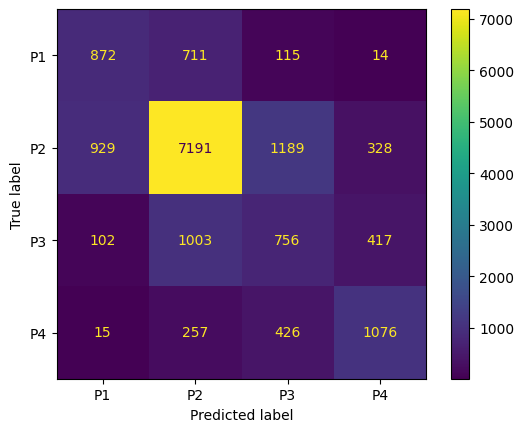

Training  XGBClassifier
XGBClassifier Confusion Matrix


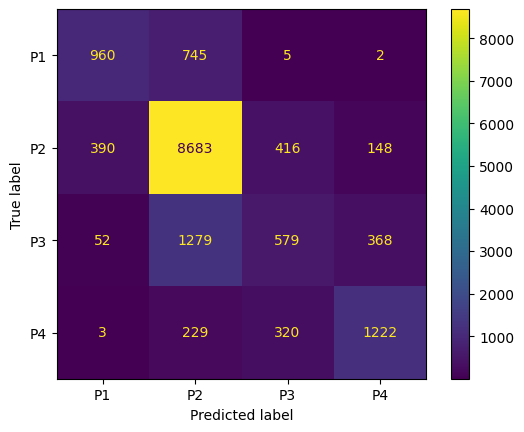

In [419]:
df3 = evaluation(results_df, X_upsampled, y_upsampled, X_test, y_test, 'Upsampled', label_encoder, rf_clf, dt_clf, xgb_clf)

In [420]:
result = pd.concat([df1, df2, df3], ignore_index= True)

In [421]:
result

,Model,Test Accuracy,Test Precision (weighted),Test Recall (weighted),Train F1 Score (weighted),Test F1 Score (weighted),Train Data,CV F1 Mean,CV F1 Std
0,RandomForestClassifier,0.736965,0.706979,0.736965,1.000000,0.701879,Original,0.706188,0.003746
1,DecisionTreeClassifier,0.647296,0.650706,0.647296,1.000000,0.648955,Original,0.654566,0.004356
2,XGBClassifier,0.746250,0.720826,0.746250,0.844099,0.724024,Original,0.722416,0.003168
3,RandomForestClassifier,0.589118,0.747142,0.589118,1.000000,0.612852,Downsampled,0.675010,0.007658
4,DecisionTreeClassifier,0.547432,0.671276,0.547432,1.000000,0.574248,Downsampled,0.576757,0.006081
5,XGBClassifier,0.606844,0.750378,0.606844,0.878943,0.631002,Downsampled,0.672103,0.007822
6,RandomForestClassifier,0.732095,0.704977,0.732095,0.999989,0.711189,Upsampled,0.828086,0.161231
7,DecisionTreeClassifier,0.642491,0.654187,0.642491,1.000000,0.647751,Upsampled,0.755648,0.110951
8,XGBClassifier,0.743069,0.718555,0.743069,0.906451,0.724387,Upsampled,0.790646,0.213880


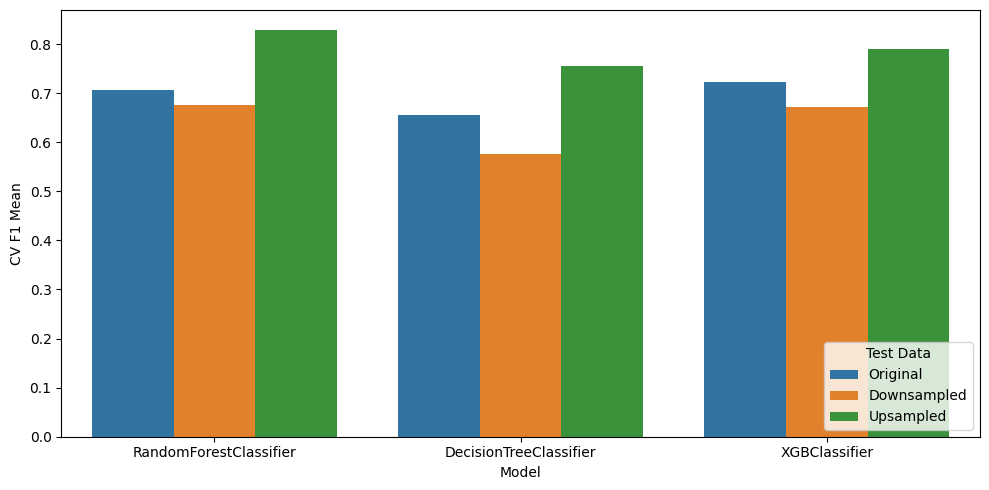

In [336]:
plt.figure(figsize= (10, 5))
sns.barplot(data = result, y = 'CV F1 Mean', x = 'Model', hue = 'Train Data' )
plt.legend(title = 'Test Data', loc = 'lower right')
plt.tight_layout()
plt.show()

# Conclusion

[Return to Contents](#Table-of-Contents) 

Random Forest, Decision Tree and XGBoost Classifiers were fitted with original, downsampled, upsampled train data and there were observations of improvement and worsening across the three base models.

1. **Upsampling helps**:

All models trained on upsampled data have a higher cross validation f1 mean compared to the ones trained on original and downsampled data, this was noticeable in Random Forest and XGB classifier.

2. **Random Forest Classifier (Upsampled):**

This has the highest cross validation f1 mean of 0.83 and a test f1 score of 0.71, however the model shows signs of over fitting with the train f1 score of 0.99 but it does generalize well.

3. **XGBoost Classifier (Upsampled):**

This has a test f1 score of 0.72 and a cross validation f1 mean of 0.79, although it has a higher cross validation variance of 0.21 it provides the best balance between performance and generalization and it has a lower overfitting (train f1: 0.9) compared to Random Forest.

4. **Lower Variance on Original Data:**

All the three models trained on original data show low variance, indicating a stable performance but overall they have lower f1 score.

5. **Downsampling data generally underperforms:**

Training on downsampled data provided the lower test and cross validation f1 score, this is likely due to the loss of majority class information.


6. **Best overall model:**

Considering test performance, cross-validation score and variance, the best model is XGBClassifier using upsampled data
- Best test f1 score: 0.7244
- Strong CV f1 mean: 0.7906
- Acceptable generalization gap, lower risk of over fitting

7. **Hyperparameter Tuning:**

Using the best model, GridsearchCV can be used to automatically search for the best parameters to improve the model.